## 데이터셋 소개
- 한국어 챗봇 데이터는 거의 없다.
  + 다행히, 한글로도 챗봇을 만들수 있도록 `Chatbot_data_for_Korean v1.0` 데이터셋이다.
- 총 11,876개의 데이터로 구성돼 있다.
  + 각 데이터는 질문과 그에 대한 대답, 그리고 주제에 대한 라벨값을 가진다.
    * 0은 일상 대화, 1은 긍정, 2는 부정의 주제를 의미한다.

## 데이터 분석
- 챗봇 데이터를 분석해보자.
- 데이터 출처: https://github.com/songys/Chatbot_data


### 구글 코랩과 구글 드라이브 연동
- 우선 데이터가 있는 폴더와 연동한다.
> Note: 런타임을 GPU로 바꾸는 것을 잊지 않는다.

In [2]:
from google.colab import drive # 패키지 불러오기
from os.path import join

ROOT = "/content/drive"     # 드라이브 기본 경로
print(ROOT)                 # print content of ROOT (Optional)
drive.mount(ROOT)           # 드라이브 기본 경로 Mount

MY_GOOGLE_DRIVE_PATH = '/content/drive/MyDrive/Colab Notebooks/2024/알파코/nlp/before_transformer/' # 프로젝트 경로
PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH) # 프로젝트 경로
print(PROJECT_PATH)

/content/drive
Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/2024/알파코/nlp/before_transformer/


In [3]:
%cd "{PROJECT_PATH}"

/content/drive/MyDrive/Colab Notebooks/2024/알파코/nlp/before_transformer


### 데이터 불러오기 및 확인
- Pandas 라이브러리를 활용한다.

In [4]:
import pandas as pd
DATA_IN_PATH = "./data_in/"
data = pd.read_csv(DATA_IN_PATH + './ChatBotData.csv', encoding='utf-8')
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


- 결과에 응답 데이터를 보면, 주로 권유의 문자열이 많이 나오는 것을 확인할 수 있다.

### 한글 형태소 설치
- 다음 코드로 형태소를 설치하도록 한다.

In [5]:
!apt-get update
!apt-get install g++ openjdk-8-jdk
!pip3 install --target=$my_path konlpy

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,197 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,632 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-s

## 트랜스포머 모델
- 트랜스포머란 구글이 2017년에 소개한 논문인 "Attention is all you need"에 나온 모델이다.
- 기존의 시퀀스 투 시퀀스의 인코더 디코더 구조를 가지고 있지만, 합성곱 신경망(CNN), 순환 신경망(RNN)을 기반으로 구성된 기존 모델과 다르게 단순히 어텐션 구조만으로 전체 모델을 만들어 어텐션 기법의 중요성을 강조함
- 어텐션이란 무엇인가?
  + 자세한 설명은 [Visualizing A Neural Machine Translation Model (Mechanics of Seq2seq Models With Attention)](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/) 참조 하시기를 바랍니다.
  + 간단하게 설명하면, 디코더에서 예측하려는 단어를 출력할 때마다 인코더의 전체 문장을 한번 더 참고하려고 한다는 점이다. 이 때, 전체 문장들이 응축되어 모여 있는 곳이 `Context Vector`라고 보면 된다.
- 트랜스포머는 `seq2seq` 모델의 `attention`에 집중을 한 모델로 보면 된다.
- 기본적으로 트랜스포머 모델은 앞서 순환 신경망 기반의 시퀀스 투 시퀀스 모델과 같이 인코더와 디코더로 구성되며 인코더에서 입력한 문장에 대한 정보와 디코더에 입력한 문장 정보를 조합해서 디코더 문장 다음에 나올 단어에 대해 생성하는 방법이다.
- 시퀀스 투 시퀀스와 다른 점은 순환 신경망을 활용하지 않고 셀프 어텐션 기법을 사용해 문장에 대한 정보를 추출한다.



## 셀프 어텐션
- 셀프 어텐션(`Self-Attention`)이란 문장에서 각 단어끼리 얼마나 관계가 있는지를 계산해서 반영하는 방법
- 즉, 셀프 어텐션을 이용하면 문장 안에서 단어들 간의 관계를 측정할 수 있다.
  + 이 값을 어텐션 스코어(`attention score`)라고 부른다.
  + "딥러닝"을 기반으로 한 예시 문장을 들면 아래와 같다.
> 딥러닝(=0.25) 텐서플로우(=0.25) 자연어(=0.25) 처리(=0.15) 아주(=0.05) 좋아요(=0.05)

- 이 어텐션 스코어 값을 하나의 테이블로 만든 것을 어텐션 맵이라고 부른다.
- 이제 이 어텐션 맵을 활용해 문장을 서로의 관계를 반영한 값으로 바꿔야 한다.

  

### 어텐션 스코어 구하는 방법
- 어텐션 구하는 기법은 우선 의미 정보를 벡터로 표현해서 유사도 점수를 계산한다.
  + 이 때의 유사도를 구하는 방법은 크게 맨하탄 거리와 같은 유사도 공식을 활용해 구하는 방법과, Dense 층을 거쳐 나온 값을 활용하는 방법이 있다.
  + 트랜스포머 모델에서는 단어 벡터끼리 내적 연산을 함으로써 어텐션 스코어를 구한다.
- 어텐션 스코어를 구한 후, 어텐션 스코어가 모여 있는 어텐션 맵에 소프트맥스 함수를 적용한다.
  + 어텐션 맵이 특정 단어에 대한 다른 단어와의 연관도 값의 확률로 나타난다. 이제 이 값을 해당 단어에 반영해야 한다. 스코어가 큰 경우 해당 단어와 관련이 높은 단어이므로 큰 값을 가져야 한다.
- 이 확률값과 기존의 각 단어 벡터를 가중합한다. 가중합이란, 각 확률값과 각 단어 벡터를 곱한 후 더하는 연산이다. 이렇게 구한 값을 해당 단어에 대한 벡터값으로 사용하게 된다.


## 모델 구현을 위한 사전 준비
- 이제 본격적으로 모델 구현을 진행한다.
- 모델 구현의 경우 큰 틀은 앞서 구현한 RNN 기반 시퀀스 투 시퀀스 모델과 거의 유사하다.
- 모델의 경우 큰 틀은 인코더와 디코더로 구성돼 있다. 따라서 입력이 인코더에 들어가면 셀프 어텐션 기법을 활용해 해당 문장의 정보를 추출하고 이 값을 토대로 디코더에서 출력 문장을 만들어 낸다.

### 패키지 불러오기
- 우선 데이터 전처리 함수 작정을 위한 패키지를 불러온다.

In [6]:
import tensorflow as tf
import numpy as np

from konlpy.tag import Twitter
import pandas as pd
import tensorflow as tf
import enum
import os
import re
import json
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from konlpy.tag import Okt # 한글 형태소

### 설정값 지정
- 토큰들의 인덱스 값 지정을 하도록 한다.
- 특별한 토큰의 의미는 아래와 같다.
  + PAD: 어떤 의미도 없는 패딩 토큰
  + SOS: 시작 토큰을 의미
  + END: 종료 토큰을 의미
  + UNK: 사전에 없는 단어를 의미


In [7]:
FILTERS = "([~.,!?\"':;)(])" # 특수문자
PAD = "<PAD>"
STD = "<SOS>"
END = "<END>"
UNK = "<UNK>"

PAD_INDEX = 0
STD_INDEX = 1
END_INDEX = 2
UNK_INDEX = 3

MARKER = [PAD, STD, END, UNK]
CHANGE_FILTER = re.compile(FILTERS)

MAX_SEQUENCE = 25

### 데이터 전처리 함수 정의
- 데이터 전처리를 위한 함수를 작성한다.

In [8]:
def load_data(path):
    # 판다스를 통해서 데이터를 불러온다.
    data_df = pd.read_csv(path, header=0)
    # 질문과 답변 열을 가져와 question과 answer에 넣는다.
    question, answer = list(data_df['Q']), list(data_df['A'])

    return question, answer


def data_tokenizer(data):
    # 토크나이징 해서 담을 배열 생성
    words = []
    for sentence in data:
        # FILTERS = "([~.,!?\"':;)(])"
        # 위 필터와 같은 값들을 정규화 표현식을
        # 통해서 모두 "" 으로 변환 해주는 부분이다.
        sentence = re.sub(CHANGE_FILTER, "", sentence)
        for word in sentence.split():
            words.append(word)
    # 토그나이징과 정규표현식을 통해 만들어진
    # 값들을 넘겨 준다.
    return [word for word in words if word]


def prepro_like_morphlized(data):
    morph_analyzer = Okt()
    result_data = list()
    for seq in tqdm(data):
        morphlized_seq = " ".join(morph_analyzer.morphs(seq.replace(' ', '')))
        result_data.append(morphlized_seq)

    return result_data


def load_vocabulary(path, vocab_path, tokenize_as_morph=False):
    # 사전을 담을 배열 준비한다.
    vocabulary_list = []
    # 사전을 구성한 후 파일로 저장 진행한다.
    # 그 파일의 존재 유무를 확인한다.
    if not os.path.exists(vocab_path):
        # 이미 생성된 사전 파일이 존재하지 않으므로
        # 데이터를 가지고 만들어야 한다.
        # 그래서 데이터가 존재 하면 사전을 만들기 위해서
        # 데이터 파일의 존재 유무를 확인한다.
        if (os.path.exists(path)):
            # 데이터가 존재하니 판단스를 통해서
            # 데이터를 불러오자
            data_df = pd.read_csv(path, encoding='utf-8')
            # 판다스의 데이터 프레임을 통해서
            # 질문과 답에 대한 열을 가져 온다.
            question, answer = list(data_df['Q']), list(data_df['A'])
            if tokenize_as_morph:  # 형태소에 따른 토크나이져 처리
                question = prepro_like_morphlized(question)
                answer = prepro_like_morphlized(answer)
            data = []
            # 질문과 답변을 extend을
            # 통해서 구조가 없는 배열로 만든다.
            data.extend(question)
            data.extend(answer)
            # 토큰나이져 처리 하는 부분이다.
            words = data_tokenizer(data)
            # 공통적인 단어에 대해서는 모두
            # 필요 없으므로 한개로 만들어 주기 위해서
            # set해주고 이것들을 리스트로 만들어 준다.
            words = list(set(words))
            # 데이터 없는 내용중에 MARKER를 사전에
            # 추가 하기 위해서 아래와 같이 처리 한다.
            # 아래는 MARKER 값이며 리스트의 첫번째 부터
            # 순서대로 넣기 위해서 인덱스 0에 추가한다.
            # PAD = "<PADDING>"
            # STD = "<START>"
            # END = "<END>"
            # UNK = "<UNKNWON>"
            words[:0] = MARKER
        # 사전을 리스트로 만들었으니 이 내용을
        # 사전 파일을 만들어 넣는다.
        with open(vocab_path, 'w', encoding='utf-8') as vocabulary_file:
            for word in words:
                vocabulary_file.write(word + '\n')

    # 사전 파일이 존재하면 여기에서
    # 그 파일을 불러서 배열에 넣어 준다.
    with open(vocab_path, 'r', encoding='utf-8') as vocabulary_file:
        for line in vocabulary_file:
            vocabulary_list.append(line.strip())

    # 배열에 내용을 키와 값이 있는
    # 딕셔너리 구조로 만든다.
    char2idx, idx2char = make_vocabulary(vocabulary_list)
    # 두가지 형태의 키와 값이 있는 형태를 리턴한다.
    # (예) 단어: 인덱스 , 인덱스: 단어)
    return char2idx, idx2char, len(char2idx)

def make_vocabulary(vocabulary_list):
    # 리스트를 키가 단어이고 값이 인덱스인
    # 딕셔너리를 만든다.
    char2idx = {char: idx for idx, char in enumerate(vocabulary_list)}
    # 리스트를 키가 인덱스이고 값이 단어인
    # 딕셔너리를 만든다.
    idx2char = {idx: char for idx, char in enumerate(vocabulary_list)}
    # 두개의 딕셔너리를 넘겨 준다.

    # 예제, [안녕, 너는, 누구야]가 데이터로 들어오면
    # word2idx는 {'안녕':0, '너는':1, '누구야':2}가 된다.
    # idx2word는 {0:'안녕', 1:'너는', 2:'누구야'}가 된다.
    return char2idx, idx2char


def enc_processing(value, dictionary, tokenize_as_morph=False):
    # 인덱스 값들을 가지고 있는
    # 배열이다.(누적된다.)
    sequences_input_index = []
    # 하나의 인코딩 되는 문장의 길이를 가지고 있다.(누적된다.)
    sequences_length = []
    # 형태소 토크나이징 사용 유무
    if tokenize_as_morph:
        value = prepro_like_morphlized(value)

    # 한줄씩 불어온다.
    for sequence in value:
        # FILTERS = "([~.,!?\"':;)(])"
        # 정규화를 사용하여 필터에 들어 있는 값들을 "" 으로 치환 한다.
        sequence = re.sub(CHANGE_FILTER, "", sequence)
        # 하나의 문장을 인코딩 할때 가지고 있기 위한 배열이다.
        sequence_index = []
        # 문장을 스페이스 단위로 자르고 있다.
        for word in sequence.split():
            # 잘려진 단어들이 딕셔너리에 존재 하는지 보고
            # 그 값을 가져와 sequence_index에 추가한다.
            if dictionary.get(word) is not None:
                sequence_index.extend([dictionary[word]])
            # 잘려진 단어가 딕셔너리에 존재 하지 않는
            # 경우 이므로 UNK(2)를 넣어 준다.
            else:
                sequence_index.extend([dictionary[UNK]])
        # 문장 제한 길이보다 길어질 경우 뒤에 토큰을 자르고 있다.
        if len(sequence_index) > MAX_SEQUENCE:
            sequence_index = sequence_index[:MAX_SEQUENCE]
        # 하나의 문장에 길이를 넣어주고 있다.
        sequences_length.append(len(sequence_index))
        # max_sequence_length보다 문장 길이가
        # 작다면 빈 부분에 PAD(0)를 넣어준다.
        sequence_index += (MAX_SEQUENCE - len(sequence_index)) * [dictionary[PAD]]
        # 인덱스화 되어 있는 값을
        # sequences_input_index에 넣어 준다.
        sequences_input_index.append(sequence_index)
    # 인덱스화된 일반 배열을 넘파이 배열로 변경한다.
    # 이유는 텐서플로우 dataset에 넣어 주기 위한 사전 작업이다.
    # 넘파이 배열에 인덱스화된 배열과 그 길이를 넘겨준다.

    # 함수 로직 요약
    # 우선, 정규 표현식을 활용하여 특수문자 모두 제거
    # 만약 어떤 단어가 단어 사전에 포함돼 있지 않다면 UNK 토큰을 넣는다.
    # 인코더 최대 길이가 5라고 가정하고 다음 예시를 참조한다.
    # 인코더 최대 길이보다 긴 경우: "안녕 우리 너무 오랜만에 만난거 같다."
    # 인코더 최대 길이보다 긴 경우 입력값: 안녕, 우리, 너무, 오랜만에, 만난거
    # 즉, "같다."가 생략된 입력값이 만들어진다. '
    # 그런데, 인코더 최대 길이보다 짧은 경우: "안녕"
    # 인코더 최대 길이보다 짧은 경우 입력값: "안녕, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>"
    # 함수의 리턴값을 보면 2개의 값이 반환되는 것을 확인할 수 있다.
    return np.asarray(sequences_input_index), sequences_length


def dec_output_processing(value, dictionary, tokenize_as_morph=False):
    # 인덱스 값들을 가지고 있는
    # 배열이다.(누적된다)
    sequences_output_index = []
    # 하나의 디코딩 입력 되는 문장의
    # 길이를 가지고 있다.(누적된다)
    sequences_length = []
    # 형태소 토크나이징 사용 유무
    if tokenize_as_morph:
        value = prepro_like_morphlized(value)
    # 한줄씩 불어온다.
    for sequence in value:
        # FILTERS = "([~.,!?\"':;)(])"
        # 정규화를 사용하여 필터에 들어 있는
        # 값들을 "" 으로 치환 한다.
        sequence = re.sub(CHANGE_FILTER, "", sequence)
        # 하나의 문장을 디코딩 할때 가지고
        # 있기 위한 배열이다.
        sequence_index = []
        # 디코딩 입력의 처음에는 START가 와야 하므로
        # 그 값을 넣어 주고 시작한다.
        # 문장에서 스페이스 단위별로 단어를 가져와서 딕셔너리의
        # 값인 인덱스를 넣어 준다.
        sequence_index = [dictionary[STD]] + [dictionary[word] if word in dictionary else dictionary[UNK] for word in sequence.split()]
        # 문장 제한 길이보다 길어질 경우 뒤에 토큰을 자르고 있다.
        if len(sequence_index) > MAX_SEQUENCE:
            sequence_index = sequence_index[:MAX_SEQUENCE]
        # 하나의 문장에 길이를 넣어주고 있다.
        sequences_length.append(len(sequence_index))
        # max_sequence_length보다 문장 길이가
        # 작다면 빈 부분에 PAD(0)를 넣어준다.
        sequence_index += (MAX_SEQUENCE - len(sequence_index)) * [dictionary[PAD]]
        # 인덱스화 되어 있는 값을
        # sequences_output_index 넣어 준다.
        sequences_output_index.append(sequence_index)
    # 인덱스화된 일반 배열을 넘파이 배열로 변경한다.
    # 이유는 텐서플로우 dataset에 넣어 주기 위한
    # 사전 작업이다.
    # 넘파이 배열에 인덱스화된 배열과 그 길이를 넘겨준다.
    return np.asarray(sequences_output_index), sequences_length


def dec_target_processing(value, dictionary, tokenize_as_morph=False):
    # 인덱스 값들을 가지고 있는
    # 배열이다.(누적된다)
    sequences_target_index = []
    # 형태소 토크나이징 사용 유무
    if tokenize_as_morph:
        value = prepro_like_morphlized(value)
    # 한줄씩 불어온다.
    for sequence in value:
        # FILTERS = "([~.,!?\"':;)(])"
        # 정규화를 사용하여 필터에 들어 있는
        # 값들을 "" 으로 치환 한다.
        sequence = re.sub(CHANGE_FILTER, "", sequence)
        # 문장에서 스페이스 단위별로 단어를 가져와서
        # 딕셔너리의 값인 인덱스를 넣어 준다.
        # 디코딩 출력의 마지막에 END를 넣어 준다.
        sequence_index = [dictionary[word] if word in dictionary else dictionary[UNK] for word in sequence.split()]
        # 문장 제한 길이보다 길어질 경우 뒤에 토큰을 자르고 있다.
        # 그리고 END 토큰을 넣어 준다
        if len(sequence_index) >= MAX_SEQUENCE:
            sequence_index = sequence_index[:MAX_SEQUENCE - 1] + [dictionary[END]]
        else:
            sequence_index += [dictionary[END]]
        # max_sequence_length보다 문장 길이가
        # 작다면 빈 부분에 PAD(0)를 넣어준다.
        sequence_index += (MAX_SEQUENCE - len(sequence_index)) * [dictionary[PAD]]
        # 인덱스화 되어 있는 값을
        # sequences_target_index에 넣어 준다.
        sequences_target_index.append(sequence_index)
    # 인덱스화된 일반 배열을 넘파이 배열로 변경한다.
    # 이유는 텐서플로우 dataset에 넣어 주기 위한 사전 작업이다.
    # 넘파이 배열에 인덱스화된 배열과 그 길이를 넘겨준다.
    return np.asarray(sequences_target_index)

- 이제 데이터 전처리를 수행한다.
- 이번에는 띄어쓰기가 아닌 형태소 단위로 토크나이즈 하는 방식으로 전처리한다.

In [9]:
PATH = 'data_in/ChatBotData.csv'
VOCAB_PATH = 'data_in/vocabulary.txt'

# os.remove(VOCAB_PATH)
inputs, outputs = load_data(PATH)
char2idx, idx2char, vocab_size = load_vocabulary(PATH, VOCAB_PATH, tokenize_as_morph=True)
index_inputs, input_seq_len = enc_processing(inputs, char2idx, tokenize_as_morph=True)
index_outputs, output_seq_len = dec_output_processing(outputs, char2idx, tokenize_as_morph=True)
index_targets = dec_target_processing(outputs, char2idx, tokenize_as_morph=True)

100%|██████████| 11823/11823 [01:14<00:00, 158.34it/s]


### 시각화 함수 정의
- 모형 시각화를 위한 함수를 정의한다.


In [10]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

### 학습 데이터 경로 정의
- 필요한 학습 데이터 경로를 정의한다.

In [11]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIGS = 'data_configs.json'

### 랜덤 시드 고정
- 실험 재현성을 위해 시드를 고정한다.

In [12]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

### 학습 데이터 불러오기
- 필요한 학습 데이터를 잘 불러오도록 한다.

In [13]:
index_inputs = np.load(open(DATA_IN_PATH + TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH + TRAIN_OUTPUTS , 'rb'))
index_targets = np.load(open(DATA_IN_PATH + TRAIN_TARGETS , 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

### 모델 파라미터 정의
- 학습 모델에 대한 파라미터를 정의한다.

In [14]:
char2idx = prepro_configs['char2idx']
end_index = prepro_configs['end_symbol']
model_name = 'transformer'
vocab_size = prepro_configs['vocab_size']
BATCH_SIZE = 64
MAX_SEQUENCE = 25
EPOCHS = 20
VALID_SPLIT = 0.1

kargs = {'model_name': model_name,
         'num_layers': 2,
         'd_model': 512,
         'num_heads': 8,
         'dff': 2048,
         'input_vocab_size': vocab_size,
         'target_vocab_size': vocab_size,
         'maximum_position_encoding': MAX_SEQUENCE,
         'end_token_idx': char2idx[end_index],
         'rate': 0.1
        }

## 모델 구현을 위한 4가지 모듈
- 트랜스포머의 각 모듈을 직접 정의한 후, 인코더와 디코더 모듈을 만들어 본다.
- 우선 모델 구현에 앞서 마스킹을 직접 처리하도록 한다.

### Masking
- 시퀀스의 일괄 처리에서 모든 패드 토큰을 마스킹 한다.
- 이렇게 하면 모델이 패딩을 입력으로 처리하지 않는다.
- 마스크는 패드 값이 0이 있는 위치를 나타낸다.
  + 이 위치에 있으면 1이 출력되고, 그렇지 않으면 0이 출력됩니다.



In [15]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

# 예제 코드
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

- 다음 함수는 미래의 토큰을 순차적으로 마스크하는 데 사용된다. (순방향 마스크 어텐션)
- 즉, 마스크는 사용하지 말아야 할 입력값을 알게 해준다.
  + 삼각형 형태의 행렬을 만들고 마스킹할 영역의 값은 1, 아닌 영역은 0으로 만들면 된다.
  + 행렬의 아래쪽 삼각형 영역이 0이 되는 하삼각행렬을 만들 텐데, 이를 만드는 방법은 `tf.linalg.bandpart(입력행렬, -1, 0)`을 실행한다.
  + 입력행렬은 모든 값이 1인 행렬을 만든다.
  + 이렇게 하 삼각행렬을 만들면 마스킹하고자 하는 영역에 1 값을 주기 위해 상수 1로부터 만들어진 하삼각행렬을 뺀다. 상수 1을 빼는 연산은 행렬에 대해 전체 행렬에 연산이 적용되는 브로드캐스팅 연산이라고 보면 된다.
- 이것은 세 번째 단어를 예측하기 위해 첫 번째 단어와 두 번째 단어만 사용된다는 것을 의미한다. 네 번째 단어를 예측하는 것과 유사하게, 첫 번째, 두 번째, 세 번째 단어만 사용된다.

In [16]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

- 위 두가지 함수를 조합하여 마스크를 생성한다.

In [17]:
def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

- Masking 처리를 완료한다.

In [18]:
enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(index_inputs, index_outputs)

### 포지셔널 인코딩
- 포지션 인코딩(Positional Encoding)은 트랜스포머 모델에 순서 정보가 반영되지 않는 문제를 해결하기 위해 사용한 기법이다.
- 포지션 인코딩 수식은 다음과 같다.
- 첫번째 수식
$$ PE_{(pos, 2i)} = sin(\frac{pos}{10000^{\frac{2i}{d_{model}}}}) $$
- 위 수식은 피처 차원에서 인덱스가 짝수인 경우에 대해 사인 함수값을 할당하는 것이다.

- 두번째 수식
$$ PE_{(pos, 2i+1)} = cos(\frac{pos}{10000^{\frac{2i}{d_{model}}}}) $$
- 위 수식은 반대로 홀수인 경우에 코사인 함수값을 할당하는 것이다.
- 사인 함수와 코사인 함수 안에 있는 식은 각 시퀀스 위치에 따라 피처 차원 인덱스에 각자 위치 정보를 달리 주고자 하는 의도를 가지고 있다.


In [19]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * i//2) / np.float32(d_model))
    return pos * angle_rates

- 포지션 임베딩을 만들 행렬을 구성하기 위해 `get_angles` 함수를 선언한다.
  + 이 함수가 $\frac{pos}{10000^{\frac{2i}{d_{model}}}}$ 값을 만드는 함수다.
  + 각 입력의 파라미터는 `pos`, `i`, `d_model`로 돼 있다.
- `pos`에는 포지션에 대한 인덱스 위치 리스트를 입력하고, `i`에는 차원에 대한 리스트를 입력한다.
- 이렇게 하여 각 순서에 따른 각도값을 얻을 수 있다.
- 이제 `get_angles`를 가지고 포지션 임베딩을 만들어 본다.

In [20]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # 짝수
    # 0::2의 뜻은 2씩 증가하는 인덱스의 배열 값만 출력
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # 홀수
    # 1::2의 뜻은 1에서부터 2씩 증가하는 인덱스의 배열 값만 출력된다.
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    # 이렇게 사인, 코사인 함수를 적용한 값은 배열에 할당한다.
    # 인코더 및 디코더 레이어에서 바로 활용할 수 있도록 `np.newaxis`를 사용하는데, 이는 새로운 차원을 만드는 것을 의미한다.
    # 새로운 차원을 만들려면 포지션 임베딩 행렬의 차원은 [배치 차원 X 시퀀스 차원 X 피처 차원]으로 구성된다.
    pos_encoding = angle_rads[np.newaxis, ...]

    # 이렇게 구성을 마친 배열은 `tf.cast`를 통해 상수가 되어 모델 그래프에 활용한다.
    return tf.cast(pos_encoding, dtype=tf.float32)

- `gen_angels` 함수의 결괏값을 출력하면 포지션과 차원별로 각기 다른 값이 순차적으로 할당돼 있다.
- 이제 이러한 값들을 짝수 차원에서는 사인 함수를, 홀수 차원에서는 코사인 함수를 적용한다.


(1, 50, 512)


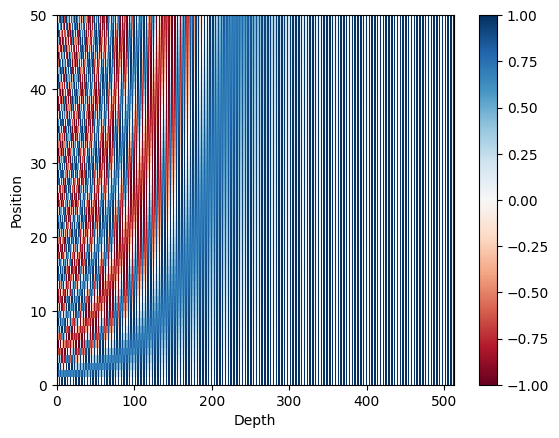

In [21]:
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### 스케일 내적 어텐션
- 기본적인 내적 어텐션의 입력은 세 가지로 구성이 된다.
- query(질의), key(키), value(값)로 들어온다.
  + 네이버 영어 사전 검색 방법을 떠올려 보자.
  + 찾고자 하는 단어는 `query`가 되고, 사전에 등록되어 있는 단어는 `key`가 된다. 마지막으로, `key`에 해당하는 단어의 의미는 `value`로 볼 수 있다.
- 위 개념을 어텐션으로 구현하는 것이다.
  + 출처: https://wikidocs.net/31379
![](https://wikidocs.net/images/page/31379/transformer14_final.PNG)
- 연산 과정을 살펴본다.
- 먼저 특정 단어에 대해 다른 모든 단어와 내적해서 어텐션 스코어값을 구한다.
  + 즉, `query`에 대해 다른 모든 `key`와 내적해서 어텐션 스코어를 구하는 것이다.
  + 이렇게 구한 스코어에 소프트맥스 함수를 적용해 확률값으로 만든 후 다시 다른 모든 단어들, 즉 `value`에 각각 곱해서 `query`와의 관계가 적용된 `value`값으로 만든다.
  + 이제 이 값을 모두 더하면 `query`에 대한 문맥 벡터가 된다.
- 여기까지는 사실 셀프 어텐션의 구조와 동일하지만, 중간에 크기를 조정하는 과정(`scaling`)이 추가된 것이다.
  + 수식은 아래와 같다.
$$ Attention(Q, K, V)= softmax(\frac{AK^{T}}{\sqrt{d_{k}}})V$$
- 위 수식처럼 `query`와 `key`를 내적한 값에 `key` 벡터의 차원 수를 제곱근한 값으로 나눈 후 소프트맥스 함수를 적용한다.
  + 여기에서 $D_{k}$는 `key` 벡터의 차원 수를 의미한다.
- 내적 어텐션 그래프는 다음과 같다.
![](https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png)
- (1) 위 그림에서 확인할 수 있는 것은 먼저 Q(query)벡터와 K(key)벡터에 대해 어텐션 스코어 맵을 만들고 크기를 조정한다. (2) 선택적으로 마스크(mask)를 적용한다. (3) 이 값에 소프트맥스 함수를 적용한 후 마지막으로 `value`에 대해 가중합을 적용한다.
- 내적 어텐션에 대한 함수는 다음과 같다.


### 순방향 마스크 어텐션(Subsequent Masked Attention)
- 문장을 예측하는 과정에서 디코더 부분에 입력이 들어가는데, 순환 신경망 구조의 경우 자신보다 앞에 있는 단어만 참고해서 단어를 예측하는 반면, 트랜스포머는 전체 문장이 들어가기 때문에 위치와 상관없이 모든 단어를 참고해서 예측을 한다.
  + 이론적으로는 무언가 이상하다. 자기 자신도 예측을 하지 않았는데, 뒤에 있는 단어를 어떻게 예측한다는 것인가?
  + 이러한 문제를 해결하기 위해 고안된 기법이 마스크 기법이다. (Masking 참조)
- 마스크의 목적은 무엇인가?
  + 자신보다 뒤에 나오는 단어를 참조하지 못하도록 행렬의 아래쪽 삼각형 부분을 제외한 값에 마스킹 처리를 해주는 것이다.
  + 이를 구현하려면 아래쪽 삼각형 부분을 제외한 값에 매우 작은 값을 넣으면 된다. 여기서는 그 값으로 -10의 9승인 `-1e9`값을 넣어준다. 이것은 특별히 의미가 있는 값이 아니라 매우 작은 어떤 값을 넣어주려는 것이다.
- 이제 앞에서 만든 `mask`를 이용해 `padding`이라는 변수를 만든다.
- 이제 이렇게 넣어준 값에 소프트맥스 함수에 매우 작은 음수값을 넣어 0값에 수렴하게 만들고, 이렇게 마스킹 처리된 부분을 참고할 수 없도록 하는 것이다.

In [22]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead)
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    # Q와 K의 곱. 어텐션 스코어 행렬.
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # 스케일링
    # dk의 루트값으로 나눠준다.
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
    # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
    # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

### 멀티 헤드 어텐션
- 멀티 헤드 어텐션은 어텐션 맵을 여럿 만들어 다양한 특징에 대한 어텐션을 볼 수 있도록 하는 방법이다.
  + 그림 출처: https://paperswithcode.com/method/multi-head-attention
![](https://paperswithcode.com/media/methods/multi-head-attention_l1A3G7a.png)
- 내적 어텐션에서 본 query, key, value에 대한 특징값을 헤드 수만큼 나눠서 리니어(Linear) 레이어를 거쳐 내적 어텐션(`Scaled Dot-Product`)를 구해서 다시 합치는 과정을 거친다.
- 멀티 헤드 어텐션의 구현은 다음과 같다.



In [23]:
class MultiHeadAttention(tf.keras.layers.Layer):
    # **kargs: 입력 파라미터로 받는다.
    # d_model: 어텐션을 연산할 때, `key`, `query`, `value`에 대한 차원을 정의하기 위한 파라미터
    # num_heads: 어텐션 헤드 수를 정의하기 위한 파라미터

    # 멀티헤드 어텐션에 대한 설정
    def __init__(self, **kargs):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = kargs['num_heads']
        self.d_model = kargs['d_model']

        # d_model의 차원 수는 헤드 개수만큼 나눠져야 하기 때문에 나머지가 발생하면 안된다.
        # assert 구문을 활용해 두 변수를 대상으로 나눗셈 시, 에러가 발생하도록 구현한다.
        assert self.d_model % self.num_heads == 0


        self.depth = self.d_model // self.num_heads

        # 어텐션에 필요한 query, key, value 값을 의미한다.
        self.wq = tf.keras.layers.Dense(kargs['d_model'])
        self.wk = tf.keras.layers.Dense(kargs['d_model'])
        self.wv = tf.keras.layers.Dense(kargs['d_model'])

        self.dense = tf.keras.layers.Dense(kargs['d_model'])

    # query, key, value에 대한 벡터를 헤드 수 만큼 분리할 수 있게 하는 함수
    # [배치 차원 X 시퀀스 차원 X 피처 차원]으로 구성된 벡터를 [배치 차원 X 헤드 차원 X 시퀀스 차원 X 피처 차원]으로 변환하는 역할 수행
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        # reshape를 활용하여 피처 차원을 헤드 수 만큼 분리할 수 있다.
        # 입력값으로 batch_size를 고정값이 아닌 변동 입력값으로 넣어주는 이유는 모델 학습 시, 입력하는 도중에 입력 배치 데이터의 시퀀스 길이가 매번 바뀌는 경우가 있을 수 있기 때문에 그렇다.
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))

        # 시퀀스, 헤드 차원만 바꿀 수 있도록 한다.
        return tf.transpose(x, perm=[0, 2, 1, 3])

    # 멀티헤드 어텐션이 동작하는 call 함수를 구현한다.
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

### 포지션-와이즈 피드 포워드 네트워크
- 셀프 어텐션 레이어를 거친 다음 피드 포워드 네트워크를 거치게 돼 있다.
- 네트워크는 한 문장에 있는 단어 토큰 벡터 각각에 대해 연산하는 네트워크로서 논문에서는 포지션-와이즈 피드 포워드 네트워크(Position-Wise Feedforward Network)라 표현한다.

$$ FFN(x) = max(0, xW_{1} + b_{1})W_{2} + b_{2} $$

- 위 수식과 같이 네트워크를 구성하는 데 두 개의 리니어 레이어를 거치고 그 사이 활성화 함수로 `Relu` 함수를 활용한다.


In [24]:
def point_wise_feed_forward_network(**kargs):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(kargs['dff'], activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(kargs['d_model'])  # (batch_size, seq_len, d_model)
    ])

- 위 연산은 `Encoder`와 `Decoder`에서 구현되는 것을 다시 확인할 수 있다.

### 리지듀얼 커넥션
- 리지듀얼 커넥션에 관한 그림은 다음과 같다.
  + 그림출처: https://wikidocs.net/images/page/31379
![](https://wikidocs.net/images/page/31379/transformer22.PNG)
- 위 그림과 같이 입력 정보 `x`가 있고, 네트워크 레이어를 거쳐 나온 정보 `F(x)`가 있다고 하면 이 두 정보를 더해 앞에 있던 정보 `x`를 보전한다.
- 어떤 함수 F(x)가 트랜스포머에서는 서브층에 해당됩니다.
  + 다시 말해 잔차 연결은 서브층의 입력과 출력을 더하는 것을 말합니다.
  + 트랜스포머에서 서브층의 입력과 출력은 동일한 차원을 갖고 있으므로, 서브층의 입력과 서브층의 출력은 덧셈 연산을 할 수 있습니다.
- 위 코드는 `Encoder`와 `Decoder` 에서 다시한번 주석으로 언급하도록 한다.


## 인코더와 디코더 구현
- 아래 그림은 지금까지 배운 모듈이 어떻게 트랜스포어의 레이어를 구성하는지 살펴보는 예제라고 보면 된다.

![](https://paperswithcode.com/media/methods/new_ModalNet-21.jpg)
- 왼쪽이 인코더, 오른쪽이 디코더가 된다.



### 인코더 레이어 클래스 구현
- 인코더 레이어 클래스를 구현하도록 한다.
- 멀티 헤드 어텐션 레이어와 피드 포워드 네트워크로 한 레이어를 구성하고, 각 레이어에는 리지듀얼 커넥션이 함께 적용 되어 있다.
  + 연산할 레이어 피드 포워드 네트워크와 레이어 노멀라이즈(=정규화)를 각각 생성하는데, 각 레이어별 뉴런을 노멀라이즈하는 역할이라고 이해하면 된다.
  + 이 부분은 트랜스포머 네트워크의 전체 구조에서 `Add & Norm`에 해당하는 부분으로 보면 된다.


In [25]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(**kargs)

        # 리지듀얼 커넥션
        self.ffn = point_wise_feed_forward_network(**kargs)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

- `__init__` 함수
  +  멀티 헤드 어텐션에 적용될 출력 차원 수 `d_model`과 헤드 수 `num_heads`를 적용한다.
  + 포지션 와이즈 피드 포워드 네트워크의 차원 수 `dff`를 적용한다.
  + 이 세 파라미터로 필요한 레이어의 출력 차원 수를 정의한다.
  + 즉, `MultiHeadAttention` 클래스를 활용해 멀티 헤드 어텐션 레이어를 생성하고, `point_wise_feed_forward_network`를 활용해 피드 포워드 네트워크를 생성한다. 마지막으로 레이어 노멀라이제이션과 드롭아웃 레이어를 생성한다.
  + 이를 활용하여 `call` 함수에서 연산하도록 한다.
- `call` 함수
  + 입력 벡터인 `x`와 패딩 마스크 `mask`를 입력 파라미터로 정의
  + 먼저 멀티 헤드 어텐션 레이어인 self.mha를 통과한다.
  + 리지듀얼 커넥션을 위해 `attn_output`과 입력값 `x`를 더하고, `self.layernorm1`을 통해 레이어 노멀라이제이션을 수행한다.
  + 이 결괏값은 `out1`에 할당한다.
  + 동일한 방법으로 와이즈 피드 포워드 네트워크를 생성 후, out2에 할당한 후에 인코더 레이어에 출력한다.
  + `dropout`을 통해 모델에 `generalization`을 할 수 있도록 도와 준다.
- 이렇게 구현한 클래스의 의미는  `여러 개의 인코더를 쎃을 수 있도록 한 것`이다.


### 인코더 클래스 구현
- 인코더를 구현하면 여러 개의 인코더 레이어를 쌓을 수 있도록 준비한 것이다.
- 이제 `Encoder` 클래스로 인코더 레이어를 쌓고, 워드 임베딩과 포지션 임베딩 정보를 받아 텍스트에 대한 컨텍스트 정보를 만든다.

In [26]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(Encoder, self).__init__()

        # num_layers: 인코더 레이어의 수
        # d_model: 워드 임베딩과 포지션 임베딩 차원 수를 결정
        self.d_model = kargs['d_model']
        self.num_layers = kargs['num_layers']

        # 워드 임베딩의 사전 수를 입력: input_vocab_size
        # 포지션 인코더의 최대 시퀀스 길이 지정: maximum_position_encoding
        self.embedding = tf.keras.layers.Embedding(kargs['input_vocab_size'], self.d_model)
        self.pos_encoding = positional_encoding(kargs['maximum_position_encoding'],
                                                self.d_model)


        self.enc_layers = [EncoderLayer(**kargs)
                           for _ in range(self.num_layers)]

        self.dropout = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, mask):

        seq_len = tf.shape(x)[1]

        # 포지션 임베딩의 경우 행렬의 크기가 고정돼 있고, 워드 임베딩의 경우 입력 길이에 따라 가변적
        # 임베딩이 할당된 후에 임베딩 차원수의 제곱근만큼에 대한 가중치를 곱한다.
        # 이 연산 과정은 각 워드 임베딩에 대해 스케일을 맞추기 위한 것이다.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, mask)

        return x  # (batch_size, input_seq_len, d_model)

### 디코더 레이어 클래스 구현
- 전체적인 구조는 인코더(그림 왼쪽)와 비슷하다.
![](https://paperswithcode.com/media/methods/new_ModalNet-21.jpg)
- 다른 점은 인코더의 경우 하나의 블록이 2개의 레이어로 구성되어 있지만, 디코더의 경우 총 3개의 레이어로 구성돼 있다.
  + 두개의 어텐션과, 하나의 피드 포워드 레이어로 구성돼 있다.
- 첫번째 어텐션은 디코더의 입력 사이의 관계 계산하는 셀프 어텐션 구조
  + 마스크 어텐션은, 말 그대로 예측을 해야 하는 디코더에서 특정 단어 이후의 단어를 참고하지 않도록 말한 마스크 기법을 의미
- 두번째 어텐션은 인코더의 결과값이 들어는데, 즉 인코더와 디코더의 관계를 확인하는 구조
  + 인코더 부분과 동일하게 피드 포워드 레이어를 적용하면 하나의 디코더 블록이 완성된다.

- 이제 코드로 구현한다.

In [27]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(**kargs)
        self.mha2 = MultiHeadAttention(**kargs)
        self.ffn = point_wise_feed_forward_network(**kargs)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout3 = tf.keras.layers.Dropout(kargs['rate'])


    def call(self, x, enc_output, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        # 첫번째 레이어
        # 디코더 벡터를 가지고 셀프 어텐션 연산을 하는 부분
        # 인코더 연산 + 리지듀얼 커녁션 + 레이어 노멀라이즈
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1)
        out1 = self.layernorm1(attn1 + x)

        # 두번째 레이어
        # 인코더 정보와 디코더 정보를 가지고 어텐션을 적용한다.
        # 즉, 인코더의 결괏값과의 관계를 확인하는 구조다.
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        # 리지듀얼 커넥션 + 피드 포워드 네트워크 연산
        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

### 디코더 클래스 구현
- 기존 인코더 레이어와 똑같다.
- 다만, 인코더 정보 벡터와 순방뱡 어텐션 마스크를 추가로 입력받는디.

In [28]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(Decoder, self).__init__()

        self.d_model = kargs['d_model']
        self.num_layers = kargs['num_layers']

        self.embedding = tf.keras.layers.Embedding(kargs['target_vocab_size'], self.d_model)
        self.pos_encoding = positional_encoding(kargs['maximum_position_encoding'], self.d_model)

        self.dec_layers = [DecoderLayer(**kargs)
                           for _ in range(self.num_layers)]
        self.dropout = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, enc_output, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

## 트랜스 모델 클래스 구현
- 이제 인코더와 디코더 모듈을 바탕으로 시퀀스 투 시퀀스 모델 형태로 구현한다.

In [29]:
class Transformer(tf.keras.Model):
    def __init__(self, **kargs):
        super(Transformer, self).__init__(name=kargs['model_name'])

        # 마지막 `end_token`에 대한 인덱스 값을 저장하는 변수로써 `inference` 함수에서 `end_token` 이후로는 더 이상 추론 모델을 하지 않도록 하는 역할을 한다.
        self.end_token_idx = kargs['end_token_idx']

        # 인코더 레이어 선언
        self.encoder = Encoder(**kargs)

        # 디코더 레이어 선언
        self.decoder = Decoder(**kargs)

        # 출력 피드 포워드 레이어 선언
        self.final_layer = tf.keras.layers.Dense(kargs['target_vocab_size'])

    def call(self, x):

        # 인코더와 디코더에 들어갈 값
        inp, tar = x

        # 패딩 마스크, 디코더에서 사용할 순방향 마스크 할당
        # 이 입력값으로 인코더, 디코더, 피드 포워드 네트워크를 거쳐 출력한다.
        # 이렇게 하면 출력에서는 입력에 대한 디코더 출력값을 받을 수 있도록 한다.
        # 그리고, 이 출력 값을 정답 데이터와 비교해서 로스값을 구한다.
        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)
        enc_output = self.encoder(inp, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, _ = self.decoder(
            tar, enc_output, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output

    def inference(self, x):
        # 기본적으로 call 함수와 비슷하다.
        inp = x
        tar = tf.expand_dims([STD_INDEX], 0)

        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)
        enc_output = self.encoder(inp, enc_padding_mask)

        predict_tokens = list()

        # 디코더에 입력할 시퀀스를 매번 생성하는 코드이며, `end_token`이 나오면 생성을 멈춘다.
        for t in range(0, MAX_SEQUENCE):
            dec_output, _ = self.decoder(tar, enc_output, look_ahead_mask, dec_padding_mask)
            final_output = self.final_layer(dec_output)
            outputs = tf.argmax(final_output, -1).numpy()
            pred_token = outputs[0][-1]
            if pred_token == self.end_token_idx:
                break
            predict_tokens.append(pred_token)
            tar = tf.expand_dims([STD_INDEX] + predict_tokens, 0)
            _, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)

        return predict_tokens

### 평가 지표 함수 구현
- 우선 모델의 평가 지표를 산출하는 함수를 구현한다.

In [30]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

def accuracy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)

### 모델 정의
- 모델을 정의한다.

In [31]:
model = Transformer(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=loss,
              metrics=[accuracy])

### Call Back 선언
- 과적합 방지를 위해 `CallBack` 선언을 진행한다.

In [41]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10, mode='max')
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)

checkpoint_path = DATA_OUT_PATH + model_name + '/.weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

./data_out/transformer -- Folder already exists 



### 모형 학습
- 이제 모형을 학습한다.

In [42]:
history = model.fit([index_inputs, index_outputs], index_targets,
                    batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/20
166/167 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8309 - loss: 0.8820
Epoch 1: val_accuracy improved from -inf to 0.83611, saving model to ./data_out/transformer/.weights.h5
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.8309 - loss: 0.8818 - val_accuracy: 0.8361 - val_loss: 1.4853
Epoch 2/20
166/167 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8380 - loss: 0.7624
Epoch 2: val_accuracy improved from 0.83611 to 0.84340, saving model to ./data_out/transformer/.weights.h5
167/167 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.8380 - loss: 0.7621 - val_accuracy: 0.8434 - val_loss: 1.4769
Epoch 3/20
166/167 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8452 - loss: 0.6373
Epoch 3: val_accuracy improved from 0.84340 to 0.85094, saving model to ./data_out/transformer/.weights.h5
167/167 ━━━━━━━━━━━━━━━━━━━━ 27s 130ms/step - accuracy: 0.8453 - loss: 0.6371 - val_accuracy: 0.8509 - val_loss: 1.4783
Epoch 4/20
166/167 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy

### 모형 결과에 대한 결과
- 성능 그래프를 출력한다.

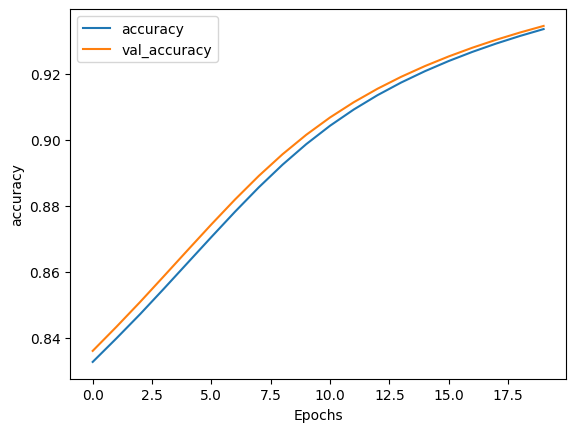

In [43]:
plot_graphs(history, 'accuracy')

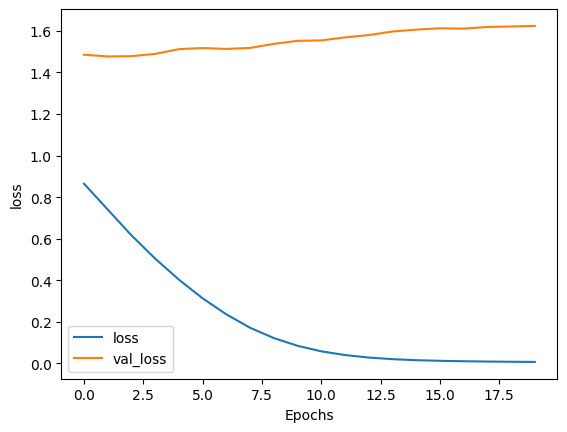

In [44]:
plot_graphs(history, 'loss')

## 모형 결과 테스트
- 저장된 모형을 불러와서 테스트를 진행한다.

In [46]:
DATA_OUT_PATH = './data_out/'
SAVE_FILE_NM = '.weights.h5'

model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

char2idx = prepro_configs['char2idx']
idx2char = prepro_configs['idx2char']

text = "승진 선물로 뭐가 좋을까요?"
test_index_inputs, _ = enc_processing([text], char2idx)
outputs = model.inference(test_index_inputs)

print(' '.join([idx2char[str(o)] for o in outputs]))

하늘 만큼 땅 만큼 축하 해 요


-